In [28]:
import pandas as pd
import xlrd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

## Load and Clean Dataset

In [29]:
file = 'CaseStudy2data.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
attrition_df = xl.parse('HR-employee-attrition Data')

#drop unneccessary columns with constant values
attrition_column = attrition_df["Attrition"]
attrition_df.drop("Attrition", axis=1, inplace=True)
attrition_df.insert(0, "Attrition", attrition_column)
attrition_df.drop('EmployeeCount', axis=1, inplace=True)
attrition_df.drop('StandardHours', axis=1, inplace=True)
attrition_df.drop('Over18', axis=1, inplace=True)

#convert attrition variable to binary
attrition_df = attrition_df.replace("Yes", 1)
attrition_df = attrition_df.replace("No", 0)

# code dummy variables, this is necessary to use sklearn
attrition_df = pd.get_dummies(attrition_df, columns=["BusinessTravel", "Department", "EducationField", "Gender", "JobRole", "MaritalStatus"], prefix=["BusinessTravel", "Department", "EduationField", "Gender", "JobRole", "MaritalStatus"])
df_without_attrition = attrition_df.drop("Attrition", axis=1)
columns_without_attrition = df_without_attrition.columns
columns_with_attrition = attrition_df.columns
attrition_df

Attrition  Age  DailyRate  DistanceFromHome  Education  EmployeeNumber  \
0             1   41       1102                 1          2               1   
1             0   49        279                 8          1               2   
2             1   37       1373                 2          2               4   
3             0   33       1392                 3          4               5   
4             0   27        591                 2          1               7   
5             0   32       1005                 2          2               8   
6             0   59       1324                 3          3              10   
7             0   30       1358                24          1              11   
8             0   38        216                23          3              12   
9             0   36       1299                27          3              13   
10            0   35        809                16          3              14   
11            0   29        153                15          2              15   
12            0   31        670                26          1              16   
13            0   34       1346                19          2              18   
14            1   28        103                24          3              19   
15            0   29       1389                21          4              20   
16            0   32        334                 5          2              21   
17            0   22       1123                16          2              22   
18            0   53       1219                 2          4              23   
19            0   38        371                 2          3              24   
20            0   24        673                11          2              26   
21            1   36       1218                 9          4              27   
22            0   34        419                 7          4              28   
23            0   21        391                15          2              30   
24            1   34        699                 6          1              31   
25            0   53       1282                 5          3              32   
26            1   32       1125                16          1              33   
27            0   42        691                 8          4              35   
28            0   44        477                 7          4              36   
29            0   46        705                 2          4              38   
30            0   33        924                 2          3              39   
31            0   44       1459                10          4              40   
32            0   30        125                 9          2              41   
33            1   39        895                 5          3              42   
34            1   24        813                 1          3              45   
35            0   43       1273                 2          2              46   
36            1   50        869                 3          2              47   
37            0   35        890                 2          3              49   
38            0   36        852                 5          4              51   
39            0   33       1141                 1          3              52   
40            0   35        464                 4          2              53   
41            0   27       1240                 2          4              54   
42            1   26       1357                25          3              55   
43            0   27        994                 8          3              56   
44            0   30        721                 1          2              57   
45            1   41       1360                12          3              58   
46            0   34       1065                23          4              60   
47            0   37        408                19          2              61   
48            0   46       1211                 5          4              62   
49    

## Split into Train and Test Set

In [30]:
rand = np.random.rand(len(attrition_df)) < 0.8

train = attrition_df[rand]
test = attrition_df[~rand]

print(train.shape)
print(test.shape)

(1176, 52)
(294, 52)


## Correlation Matrix to Identify Covariance

In [31]:
train.corr().abs()

Attrition       Age  DailyRate  \
Attrition                           1.000000  0.160886   0.068682   
Age                                 0.160886  1.000000   0.002740   
DailyRate                           0.068682  0.002740   1.000000   
DistanceFromHome                    0.085020  0.006067   0.014717   
Education                           0.032819  0.224379   0.018474   
EmployeeNumber                      0.023009  0.008226   0.039188   
EnvironmentSatisfaction             0.070839  0.002550   0.019476   
HourlyRate                          0.018306  0.027275   0.018647   
JobInvolvement                      0.131217  0.048968   0.047550   
JobLevel                            0.172347  0.483237   0.004093   
JobSatisfaction                     0.100343  0.009191   0.047563   
MonthlyIncome                       0.162446  0.475263   0.002368   
MonthlyRate                         0.026777  0.029059   0.041721   
NumCompaniesWorked                  0.038456  0.297520   0.038460   
OverTime                            0.259366  0.016806   0.018090   
PercentSalaryHike                   0.003121  0.010345   0.013275   
PerformanceRating                   0.002764  0.015136   0.009347   
RelationshipSatisfaction            0.019985  0.027097   0.012154   
StockOptionLevel                    0.127864  0.046825   0.026253   
TotalWorkingYears                   0.183069  0.673023   0.020029   
TrainingTimesLastYear               0.072850  0.016153   0.017372   
WorkLifeBalance                     0.072827  0.012124   0.044577   
YearsAtCompany                      0.137316  0.304469   0.021670   
YearsInCurrentRole                  0.164157  0.210181   0.020316   
YearsSinceLastPromotion             0.034077  0.205150   0.018374   
YearsWithCurrManager                0.158275  0.201871   0.025964   
BusinessTravel_Non-Travel           0.079285  0.015193   0.007674   
BusinessTravel_Travel_Frequently    0.136633  0.022519   0.017428   
BusinessTravel_Travel_Rarely        0.064141  0.029490   0.009815   
Department_Human Resources          0.020830  0.037692   0.023233   
Department_Research & Development   0.071653  0.022751   0.023215   
Department_Sales                    0.065211  0.039162   0.014262   
EduationField_Human Resources       0.053698  0.009337   0.044328   
EduationField_Life Sciences         0.034538  0.018645   0.002137   
EduationField_Marketing             0.045528  0.015991   0.077872   
EduationField_Medical               0.047885  0.004910   0.043172   
EduationField_Other                 0.021116  0.062643   0.008849   
EduationField_Technical Degree      0.081311  0.010202   0.031084   
Gender_Female                       0.011572  0.039214   0.027408   
Gender_Male                         0.011572  0.039214   0.027408   
JobRole_Healthcare Representative   0.081692  0.106938   0.031908   
JobRole_Human Resources             0.042699  0.015368   0.007283   
JobRole_Laboratory Technician       0.115146  0.131982   0.008766   
JobRole_Manager                     0.080883  0.287902   0.021560   
JobRole_Manufacturing Director      0.090072  0.049742   0.003627   
JobRole_Research Director           0.081839  0.170693   0.001624   
JobRole_Research Scientist          0.006514  0.132576   0.017454   
JobRole_Sales Executive             0.017615  0.026883   0.006871   
JobRole_Sales Representative        0.141817  0.165796   0.020674   
MaritalStatus_Divorced              0.092982  0.048404   0.027940   
MaritalStatus_Married               0.076479  0.068632   0.061082   
MaritalStatus_Single                0.164196  0.116090   0.089813   

                                   DistanceFromHome  Education  \
Attrition                                  0.085020   0.032819   
Age                                        0.006067   0.224379   
DailyRate                                  0.014717   0.018474   
DistanceFromHome                           1.000000   0.004129   
Education                                  0.00

Based off looking at the correlation matrix above, there are not any values that stand out as extremly correlated (0.8). Thus no variables will be removed.

## Recursive Feature Elimination

In [32]:
np.set_printoptions(precision=3)

values = train.values

X = values[:,1:(len(train.columns))]
Y = values[:,0]

test_values = test.values
X_test = test_values[:,1:(len(test.columns))]
Y_test = test_values[:,0]


number_of_features_to_select = 5
# feature extraction
model = LogisticRegression()
rfe = RFE(model, number_of_features_to_select)
fit = rfe.fit(X, Y)
print(fit.support_)
print(fit.ranking_)
true_indexes = [i for i, x in enumerate(fit.support_) if x == True]
features = np.asarray(columns_without_attrition[true_indexes])
print(features)

predictions = rfe.predict(X_test)
print('Accuracy of RFE on test set: {:.5f}'.format(fit.score(X_test, Y_test)))


[False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False  True False False False False False  True
 False False  True]
[41 44 39 40 45 15 43  8 10 12 46 47 33  1 42 35 34 25 38 28 13 37 30 31
 36  3  5 21 29 23 22  1 20 32 19 18  4 17 16 11  6  1 26  2 14 24  7  1
  9 27  1]
['OverTime' 'EduationField_Human Resources'
 'JobRole_Laboratory Technician' 'JobRole_Sales Representative'
 'MaritalStatus_Single']
Accuracy of RFE on test set: 0.84014


## Feature Importance With ExtraTreesClassifier

In [33]:
from sklearn.ensemble import ExtraTreesClassifier
# feature extraction
model = ExtraTreesClassifier()
fit = model.fit(X, Y)

importances = model.feature_importances_
print(importances)

idxs = np.argsort(importances)[-(number_of_features_to_select):]
features = np.asarray(columns_without_attrition[idxs])
print(list(reversed(features.tolist())))

predictions = model.predict(X_test)
print('Accuracy of extra trees classifier on test set: {:.5f}'.format(model.score(X_test, Y_test)))


[0.037 0.021 0.028 0.021 0.023 0.028 0.03  0.025 0.019 0.03  0.04  0.024
 0.022 0.08  0.032 0.009 0.031 0.024 0.031 0.028 0.022 0.028 0.028 0.021
 0.029 0.01  0.022 0.015 0.004 0.008 0.009 0.005 0.015 0.008 0.017 0.009
 0.017 0.013 0.014 0.005 0.004 0.016 0.002 0.008 0.002 0.01  0.012 0.009
 0.008 0.013 0.037]
['OverTime', 'MonthlyIncome', 'Age', 'MaritalStatus_Single', 'PercentSalaryHike']
Accuracy of extra trees classifier on test set: 0.84014


## Random Forrest

In [34]:
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X, Y)

clf.predict(X_test)

# preds = iris.target_names[clf.predict(test[features])]
train.describe()
test.describe()
preds = clf.predict_proba(X_test)

predictions = []
attrition_count = 0
not_attrition_count = 0
for pred in preds:
    if pred[0] >= pred[1]:
        not_attrition_count = not_attrition_count + 1
        predictions.append('No Attrition') 
    else:
        attrition_count = attrition_count + 1
        predictions.append('Attrition')
    
print("Attrition count: ")
print(attrition_count)
print("Not Attrition count: ")
print(not_attrition_count)
print('Accuracy of random forrest on test set: {:.5f}'.format(clf.score(X_test, Y_test)))
print(sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), columns_without_attrition), reverse=True)[:5])



Attrition count: 
13
Not Attrition count: 
281
Accuracy of random forrest on test set: 0.85714
[(0.0777, 'MonthlyIncome'), (0.058, 'DailyRate'), (0.052, 'OverTime'), (0.0483, 'MonthlyRate'), (0.0439, 'TotalWorkingYears')]


## Logistic Regression

In [35]:
logreg = LogisticRegression()
logreg.fit(X, Y)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.5f}'.format(logreg.score(X_test, Y_test)))
coef = np.std(X, 0)*logreg.coef_[0]
print(sorted(list(zip(coef, columns_without_attrition)))[-5:])


Accuracy of logistic regression classifier on test set: 0.87755
[(0.2970550427405585, 'NumCompaniesWorked'), (0.3293442098258015, 'DistanceFromHome'), (0.4609882794946754, 'YearsAtCompany'), (0.6482653245114295, 'OverTime'), (0.6648602607569843, 'YearsSinceLastPromotion')]


## Investigating Possible Correlation

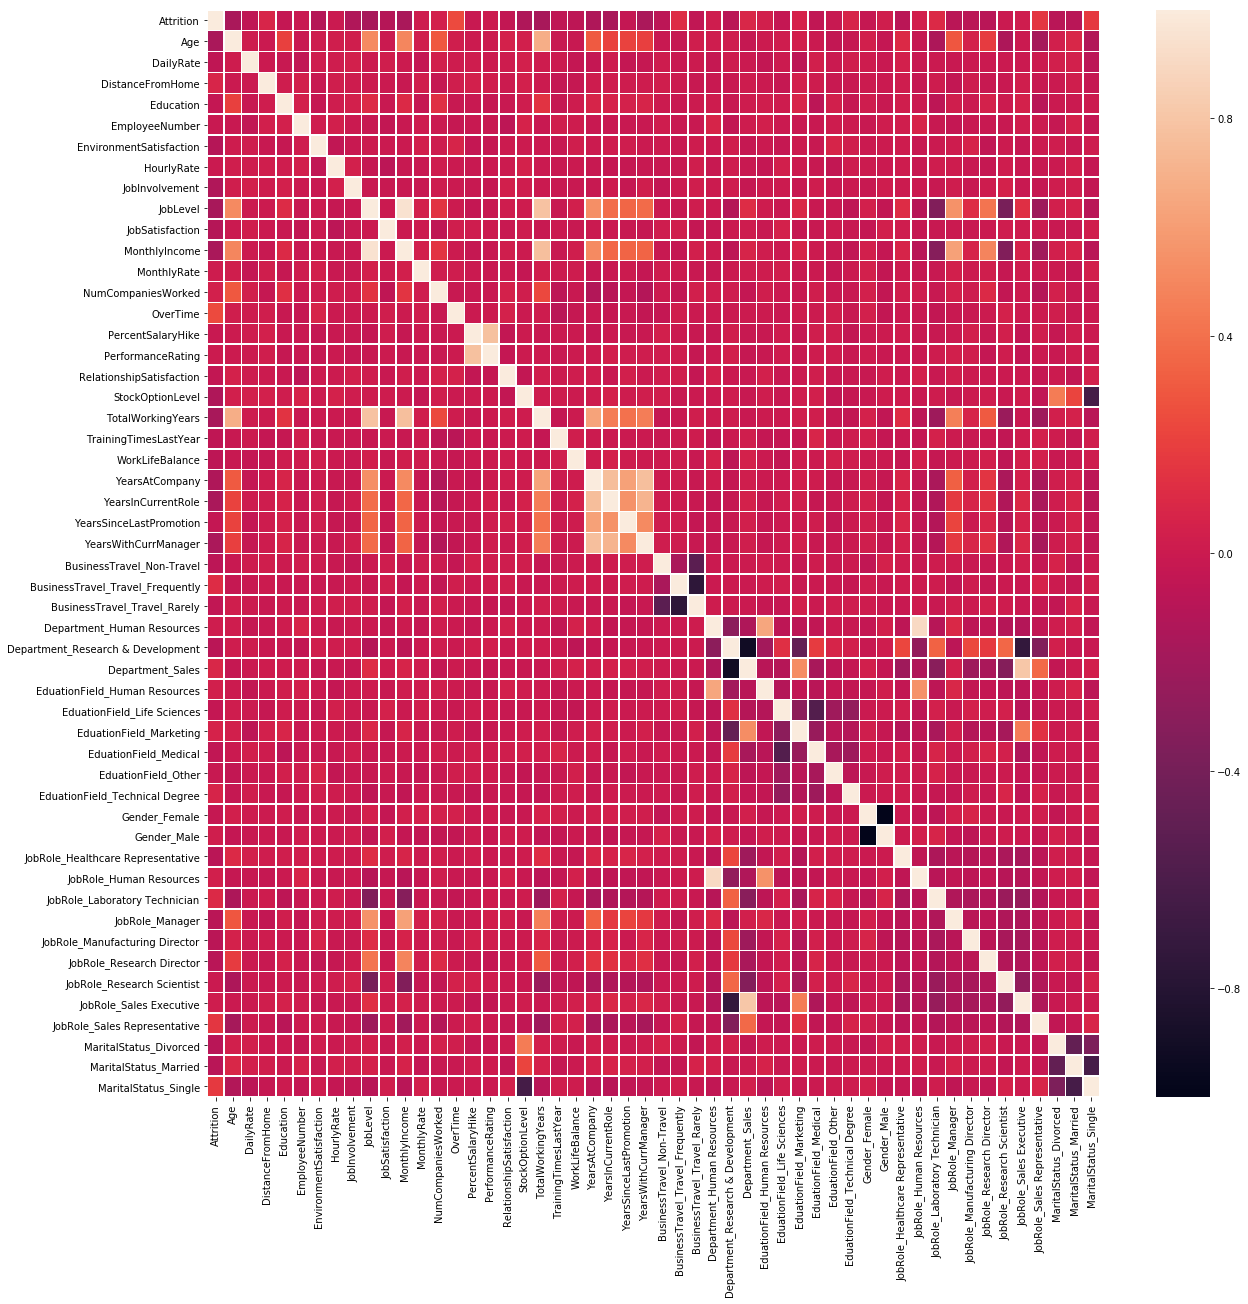

In [36]:
plt.figure(figsize = (20,20))
sns.heatmap(attrition_df.corr(), 
        xticklabels=columns_with_attrition,
        yticklabels=columns_with_attrition, linewidths=.6)